# Introduction and Description of the Problem
Seattle is a city that has grown rapidly over the last decade. From 2010-2018, the population of Seattle grew 22.4%, whereas the population of the United States grew 6.0%. As the city continues to grow, it is important for potential business owners to examine the types of businesses in the area. For example, a restaurant owner may not want to open a restaurant in a neighborhood that has many similar types of restaurants. To examine the types of venues in the area, Foursquare location data can be leveraged in order to select a neighborhood that is not saturated with a particular type of restaurant. Analyzing median income can also be useful in determining price points for the menu. To explore different neighborhoods in Seattle, I will create a map of the neighborhoods showing median income and clustered by venue density.

# Data
Seattle neighborhoods are not official, and many of the boundaries are informal. To examine neighborhoods and districts, I will be pulling in a GeoJSON map of the Seattle neighborhoods from the City of Seattle. This file includes the smaller neighborhoods, larger neighborhoods, and latitude and longitude. For this project, I will be focusing on the neighborhoods that are located near central Seattle. In order to examine the neighborhoods, I will leverage Foursquare API data to retrieve the 50 most common venues of each of the smaller neighborhoods in Seattle. I will then use a k-means algorithm to cluster the neighborhoods. By examining the most common venues in the clusters, I can then identify appropriate neighborhoods for a restaurant. I will also pull in data of median incomes by neighborhood. By examining median incomes, this will help business owners decide reasonable prices.

In [2]:
## Import packages 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import requests

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 

# geojson_utils for centroid
!pip install geojson_utils
from geojson_utils import centroid

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Packages imported')

Solving environment: done

# All requested packages already installed.

Packages imported


## Download GeoJSON file

In [3]:
!wget -q -O 'seattle_data.json' https://opendata.arcgis.com/datasets/b76cdd45f7b54f2a96c5e97f2dda3408_2.geojson
with open('seattle_data.json') as my_data:
    sea_data = json.load(my_data)


In [5]:
seamap = r'seattle_data.json'

In [6]:
#examine data
seattle_data = sea_data['features']
seattle_data[0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'PERIMETER': 617.8430000000001,
  'S_HOOD': 'OOO',
  'L_HOOD': ' ',
  'L_HOODID': 0,
  'SYMBOL': 0,
  'SYMBOL2': 0,
  'AREA': 3588.443,
  'HOODS_': 2,
  'HOODS_ID': 0,
  'SHAPE_Length': 617.8426138070929,
  'SHAPE_Area': 3588.4423845993088},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.27397895294007, 47.69522647266365],
    [-122.27407220246535, 47.695293842824675],
    [-122.27415274041662, 47.695342180047156],
    [-122.27421002908615, 47.695357650677835],
    [-122.2742771017127, 47.69535980177168],
    [-122.27434013838452, 47.69536286057418],
    [-122.27441141568609, 47.69537018544237],
    [-122.27451939278767, 47.695382787047954],
    [-122.27462569008337, 47.69540804826701],
    [-122.27469749983605, 47.69543455978649],
    [-122.27480765198865, 47.695452360629474],
    [-122.27488321789819, 47.695467856678164],
    [-122.27496776311979, 47.695514214768764],
    [-122.2750564757128, 47.69556437585359],
    [-12

# Method

From the GeoJSON map of the Seattle neighborhoods, I created a dataframe including Neighborhood, District, and Latitude and Longitude of the center of the neighborhood.  I then selected only neighborhoods that were in the Downtown and Central Area districts.

In [7]:
# define the dataframe columns
column_names = ['Neighborhood', 'District','Latitude', 'Longitude'] 

# instantiate the dataframe
seattle_neighborhoods = pd.DataFrame(columns=column_names)
seattle_neighborhoods

Empty DataFrame
Columns: [Neighborhood, District, Latitude, Longitude]
Index: []

Create a dataframe of the Seattle neighborhoods, using the centroid of the neighborhood as the coordinates.

In [8]:
for data in seattle_data:
    neighborhood_name = data['properties']['S_HOOD']
    neighborhood_district = data['properties']['L_HOOD']  
    
    box_str = json.dumps(data['geometry'])
    box = json.loads(box_str)
    coords = centroid(box)['coordinates']
        
    neighborhood_lat = coords[1]
    neighborhood_lon = coords[0]
    
    seattle_neighborhoods = seattle_neighborhoods.append({'Neighborhood': neighborhood_name,
                                                          'District': neighborhood_district,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [9]:
#clean up dataframe by removing duplicates and sorting by neighborhood
seattle_neighborhoods=seattle_neighborhoods.drop_duplicates()
seattle_neighborhoods = seattle_neighborhoods.sort_values(by='Neighborhood')


For this project, I am focusing on the Downtown and Central Area districts, so I created a new dataframe with only neighborhoods in these districts.

In [10]:
seattle = seattle_neighborhoods.loc[seattle_neighborhoods['District'].isin(['DOWNTOWN','CENTRAL AREA'])]
seattle


Neighborhood      District   Latitude   Longitude
57                   Atlantic  CENTRAL AREA  47.593588 -122.303870
59                   Belltown      DOWNTOWN  47.615510 -122.344271
61  Central Business District      DOWNTOWN  47.608184 -122.334878
62                 First Hill      DOWNTOWN  47.609914 -122.323974
53      Harrison/Denny-Blaine  CENTRAL AREA  47.623605 -122.287206
60     International District      DOWNTOWN  47.598073 -122.321896
55                     Leschi  CENTRAL AREA  47.600022 -122.291119
52                    Madrona  CENTRAL AREA  47.613305 -122.288932
56                       Mann  CENTRAL AREA  47.611746 -122.299369
54                      Minor  CENTRAL AREA  47.608831 -122.309213
58                Pike-Market      DOWNTOWN  47.609459 -122.342300
64             Pioneer Square      DOWNTOWN  47.597780 -122.334066
63             Yesler Terrace      DOWNTOWN  47.603178 -122.321044

Because the neighborhoods are informal, the median incomes of the neighborhoods are not readily available from a single source.  I created a csv file of median income from multiple sources (https://statisticalatlas.com/, https://www.city-data.com/, and https://www.point2homes.com/). This csv file was then saved to my GitHub repository.  The csv file was then imported as a dataframe and merged with the dataframe of neighborhoods and coordinates. 

In [11]:
inc = pd.read_csv('https://raw.githubusercontent.com/fwchu07/Coursera_Capstone/master/Seattle_MedianIncome.csv')
inc

Neighborhood  MedianIncome
0                    Atlantic         62180
1                    Belltown         83543
2   Central Business District         68750
3                  First Hill         47970
4       Harrison/Denny-Blaine        185383
5      International District         35122
6                      Leschi        111191
7                     Madrona        135293
8                        Mann         98639
9                       Minor         64646
10                Pike-Market         81782
11             Pioneer Square         55479
12             Yesler Terrace         36318

In [12]:
seattle = pd.merge(seattle, inc)
seattle

Neighborhood      District   Latitude   Longitude  \
0                    Atlantic  CENTRAL AREA  47.593588 -122.303870   
1                    Belltown      DOWNTOWN  47.615510 -122.344271   
2   Central Business District      DOWNTOWN  47.608184 -122.334878   
3                  First Hill      DOWNTOWN  47.609914 -122.323974   
4       Harrison/Denny-Blaine  CENTRAL AREA  47.623605 -122.287206   
5      International District      DOWNTOWN  47.598073 -122.321896   
6                      Leschi  CENTRAL AREA  47.600022 -122.291119   
7                     Madrona  CENTRAL AREA  47.613305 -122.288932   
8                        Mann  CENTRAL AREA  47.611746 -122.299369   
9                       Minor  CENTRAL AREA  47.608831 -122.309213   
10                Pike-Market      DOWNTOWN  47.609459 -122.342300   
11             Pioneer Square      DOWNTOWN  47.597780 -122.334066   
12             Yesler Terrace      DOWNTOWN  47.603178 -122.321044   

    MedianIncome  
0          62180  
1          83543  
2          68750  
3          47970  
4         185383  
5          35122  
6         111191  
7         135293  
8          98639  
9          64646  
10         81782  
11         55479  
12         36318

## Create map of Seattle

I then used folium to create a map of Seattle with the neighborhoods with markers to indicate the neighborhoods.  

In [13]:
#Determine coordinates of Seattle

address = 'Seattle, WA'
geolocator = Nominatim(user_agent="sea_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Seattle are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Seattle are 47.6038321, -122.3300624.


In [14]:
# create map of Seattle using latitude and longitude values
sea_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, district, neighborhood in zip(seattle['Latitude'], seattle['Longitude'], seattle['District'], seattle['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sea_map)  
    
sea_map

## Foursquare Data

To examine venues in the area, I used the Foursquare API to generate a list of the top 50 venues within a 500 m radius.  I created a dataframe of the number of venues retrieved for each neighborhood.  I also created a dataframe of the 10 most common venues in each neighborhood.  

In [36]:
#Foursquare credential @hidden_cell
CLIENT_ID = 'AQQ2KQZCE1LFFPTLQ0IYPQIFPHHDOW2LFTFW2D5A0QOBUREA' # your Foursquare ID
CLIENT_SECRET = 'JIVKIGZS5QXUCVAFF5FYDY4UHVMBKUKT2OQD40BBPV1EWYGN' # your Foursquare Secret
VERSION = '20191231'
LIMIT = 50


In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
#create dataframe of venues
sea_venues = getNearbyVenues(names=seattle['Neighborhood'],
                                   latitudes=seattle['Latitude'],
                                   longitudes=seattle['Longitude']
                                  )

Atlantic
Belltown
Central Business District
First Hill
Harrison/Denny-Blaine
International District
Leschi
Madrona
Mann
Minor
Pike-Market
Pioneer Square
Yesler Terrace


This is the number of venues (max 50) found for each neighborhood.  

In [39]:
sea_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Atlantic                                      11                      11   
Belltown                                      50                      50   
Central Business District                     50                      50   
First Hill                                    50                      50   
Harrison/Denny-Blaine                         13                      13   
International District                        50                      50   
Leschi                                         7                       7   
Madrona                                       18                      18   
Mann                                          28                      28   
Minor                                         11                      11   
Pike-Market                                   50                      50   
Pioneer Square                                50                      50   
Yesler Terrace                                20                      20   

                           Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                        
Atlantic                      11              11               11   
Belltown                      50              50               50   
Central Business District     50              50               50   
First Hill                    50              50               50   
Harrison/Denny-Blaine         13              13               13   
International District        50              50               50   
Leschi                         7               7                7   
Madrona                       18              18               18   
Mann                          28              28               28   
Minor                         11              11               11   
Pike-Market                   50              50               50   
Pioneer Square                50              50               50   
Yesler Terrace                20              20               20   

                           Venue Category  
Neighborhood                               
Atlantic                               11  
Belltown                               50  
Central Business District              50  
First Hill                             50  
Harrison/Denny-Blaine                  13  
International District                 50  
Leschi                                  7  
Madrona                                18  
Mann                                   28  
Minor                                  11  
Pike-Market                            50  
Pioneer Square                         50  
Yesler Terrace                         20

In [40]:
# one hot encoding
sea_onehot = pd.get_dummies(sea_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sea_onehot['Neighborhood'] = sea_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sea_onehot.columns[-1]] + list(sea_onehot.columns[:-1])
sea_onehot = sea_onehot[fixed_columns]

sea_onehot.head()

Neighborhood  Adult Boutique  American Restaurant  Art Gallery  Art Museum  \
0     Atlantic               0                    0            0           0   
1     Atlantic               0                    0            0           0   
2     Atlantic               0                    0            0           0   
3     Atlantic               0                    0            0           0   
4     Atlantic               0                    0            0           0   

   Asian Restaurant  Bakery  Bar  Beer Bar  Bookstore  Botanical Garden  \
0                 0       0    0         0          0                 0   
1                 0       0    0         0          0                 0   
2                 0       0    0         0          0                 0   
3                 0       0    0         0          0                 0   
4                 0       0    0         0          0                 0   

   Boutique  Bowling Alley  Breakfast Spot  Brewery  Bubble Tea Shop  \
0         0              0               0        0                0   
1         0              0               0        0                0   
2         0              0               0        0                0   
3         0              0               0        0                0   
4         0              0               0        0                0   

   Building  Burger Joint  Bus Station  Bus Stop  Café  Candy Store  \
0         0             0            0         0     0            0   
1         0             0            0         0     0            0   
2         0             0            0         0     0            0   
3         0             0            0         0     1            0   
4         0             0            0         0     0            0   

   Cantonese Restaurant  Cheese Shop  Chinese Restaurant  Chocolate Shop  \
0                     0            0                   0               0   
1                     0            0                   0               0   
2                     0            0                   0               0   
3                     0            0                   0               0   
4                     0            0                   0               0   

   Clothing Store  Cocktail Bar  Coffee Shop  Concert Hall  Convenience Store  \
0               0             0            0             0                  0   
1               0             0            0             0                  0   
2               0             0            0             0                  0   
3               0             0            0             0                  0   
4               0             0            0             0                  0   

   Cupcake Shop  Dance Studio  Deli / Bodega  Dessert Shop  Dive Bar  \
0             0             0              0             0         0   
1             0             0              0             0         0   
2             0             0              0             0         0   
3             0             0              0             0         0   
4             0             0              0             0         0   

   Donut Shop  Dry Cleaner  Dumpling Restaurant  Ethiopian Restaurant  \
0           0            0                    0                     0   
1           0            0                    0                     0   
2           0            0                    0                     0   
3           0            0                    0                     0   
4           0            0                    0                     0   

   Falafel Restaurant  Farmers Market  Filipino Restaurant  Fish Market  \
0                   0               0                    0            0   
1                   0               0                    0            0   
2                   0               0                    0            0   
3                   0               0                    0            0   
4                  

In [41]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
sea_grouped = sea_onehot.groupby('Neighborhood').mean().reset_index()
sea_grouped

Neighborhood  Adult Boutique  American Restaurant  \
0                    Atlantic            0.00             0.000000   
1                    Belltown            0.00             0.000000   
2   Central Business District            0.00             0.060000   
3                  First Hill            0.02             0.000000   
4       Harrison/Denny-Blaine            0.00             0.000000   
5      International District            0.00             0.000000   
6                      Leschi            0.00             0.142857   
7                     Madrona            0.00             0.000000   
8                        Mann            0.00             0.000000   
9                       Minor            0.00             0.000000   
10                Pike-Market            0.00             0.020000   
11             Pioneer Square            0.00             0.000000   
12             Yesler Terrace            0.00             0.000000   

    Art Gallery  Art Museum  Asian Restaurant    Bakery       Bar  Beer Bar  \
0      0.000000        0.00          0.000000  0.000000  0.000000      0.00   
1      0.020000        0.00          0.000000  0.060000  0.040000      0.02   
2      0.000000        0.02          0.020000  0.000000  0.000000      0.00   
3      0.000000        0.02          0.040000  0.040000  0.040000      0.00   
4      0.000000        0.00          0.000000  0.076923  0.000000      0.00   
5      0.000000        0.00          0.000000  0.060000  0.000000      0.00   
6      0.000000        0.00          0.000000  0.000000  0.000000      0.00   
7      0.000000        0.00          0.055556  0.000000  0.055556      0.00   
8      0.000000        0.00          0.035714  0.000000  0.071429      0.00   
9      0.090909        0.00          0.000000  0.000000  0.000000      0.00   
10     0.000000        0.00          0.020000  0.040000  0.000000      0.00   
11     0.000000        0.00          0.000000  0.000000  0.020000      0.00   
12     0.000000        0.05          0.000000  0.000000  0.000000      0.00   

    Bookstore  Botanical Garden  Boutique  Bowling Alley  Breakfast Spot  \
0    0.000000              0.00      0.00           0.00            0.00   
1    0.000000              0.02      0.00           0.00            0.02   
2    0.000000              0.00      0.00           0.00            0.00   
3    0.000000              0.00      0.00           0.02            0.00   
4    0.000000              0.00      0.00           0.00            0.00   
5    0.020000              0.00      0.02           0.00            0.00   
6    0.000000              0.00      0.00           0.00            0.00   
7    0.000000              0.00      0.00           0.00            0.00   
8    0.035714              0.00      0.00           0.00            0.00   
9    0.000000              0.00      0.00           0.00            0.00   
10   0.020000              0.00      0.00           0.00            0.06   
11   0.020000              0.00      0.00           0.00            0.02   
12   0.000000              0.00      0.00           0.00            0.00   

    Brewery  Bubble Tea Shop  Building  Burger Joint  Bus Station  Bus Stop  \
0      0.00             0.00      0.00      0.000000     0.181818  0.000000   
1      0.00             0.00      0.00      0.000000     0.000000  0.000000   
2      0.00             0.00      0.00      0.020000     0.000000  0.000000   
3      0.04             0.00      0.00      0.020000     0.000000  0.000000   
4      0.00             0.00      0.00      0.000000     0.000000  0.000000   
5      0.00             0.04      0.00      0.000000     0.000000  0.000000   
6      0.00             0.00      0.00      0.000000     0.000000  0.000000   
7      0.00             0.00      0.00      0.000000     0.000000  0.000000   
8      0.00             0.00      0.00      0.035714     0.000000  0.000000   
9      0.00             0.00      0.00      0.000000     0.000000  0.09090

In [42]:
num_top_venues = 5

for hood in sea_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sea_grouped[sea_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Atlantic----
                                      venue  freq
0                               Bus Station  0.18
1                 South American Restaurant  0.09
2                            Scenic Lookout  0.09
3  Residential Building (Apartment / Condo)  0.09
4                            Rental Service  0.09


----Belltown----
                venue  freq
0    Sushi Restaurant  0.06
1              Bakery  0.06
2  Italian Restaurant  0.04
3        Cocktail Bar  0.04
4                 Bar  0.04


----Central Business District----
                     venue  freq
0                    Hotel  0.12
1              Coffee Shop  0.12
2      American Restaurant  0.06
3  New American Restaurant  0.06
4                      Spa  0.04


----First Hill----
              venue  freq
0       Coffee Shop  0.06
1    Sandwich Place  0.06
2  Asian Restaurant  0.04
3            Bakery  0.04
4               Bar  0.04


----Harrison/Denny-Blaine----
              venue  freq
0              Park  0.08
1

## Create dataframe of venues

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sea_venues_sorted = pd.DataFrame(columns=columns)
sea_venues_sorted['Neighborhood'] = sea_grouped['Neighborhood']

for ind in np.arange(sea_grouped.shape[0]):
    sea_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sea_grouped.iloc[ind, :], num_top_venues)

sea_venues_sorted

Neighborhood  1st Most Common Venue  2nd Most Common Venue  \
0                    Atlantic            Bus Station         Rental Service   
1                    Belltown       Sushi Restaurant                 Bakery   
2   Central Business District            Coffee Shop                  Hotel   
3                  First Hill         Sandwich Place            Coffee Shop   
4       Harrison/Denny-Blaine            Dry Cleaner            Pizza Place   
5      International District     Chinese Restaurant  Vietnamese Restaurant   
6                      Leschi                   Park             Playground   
7                     Madrona              Gift Shop            Coffee Shop   
8                        Mann   Ethiopian Restaurant            Coffee Shop   
9                       Minor            Coffee Shop               Bus Stop   
10                Pike-Market                  Hotel           Cocktail Bar   
11             Pioneer Square            Coffee Shop           Cocktail Bar   
12             Yesler Terrace  Vietnamese Restaurant           Noodle House   

      3rd Most Common Venue      4th Most Common Venue  \
0                    Tunnel  South American Restaurant   
1                Restaurant               Cocktail Bar   
2   New American Restaurant        American Restaurant   
3                    Lounge                      Hotel   
4                      Café                Gas Station   
5                    Bakery               Dessert Shop   
6       American Restaurant              Grocery Store   
7           Thai Restaurant                 Playground   
8             Deli / Bodega                 Food Truck   
9                Playground                 Food Truck   
10              Coffee Shop             Breakfast Spot   
11                     Café         Italian Restaurant   
12        Korean Restaurant            Thai Restaurant   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                      Park            Skate Park        Scenic Lookout   
1               Coffee Shop    Italian Restaurant                   Bar   
2              Concert Hall        Clothing Store               Theater   
3          Asian Restaurant                Bakery                   Bar   
4                 Surf Spot      Sushi Restaurant                   Spa   
5         Hotpot Restaurant                  Café       Bubble Tea Shop   
6                 Pet Store           Pizza Place           Yoga Studio   
7        Italian Restaurant          Cupcake Shop    Seafood Restaurant   
8                       Bar            Taco Place             Mini Golf   
9            Soccer Stadium               Theater     Convenience Store   
10  New American Restaurant    Italian Restaurant     French Restaurant   
11      Sporting Goods Shop                Lounge    Mexican Restaurant   
12               Poke Place        Sandwich Place     Convenience Store   

     8th Most Common Venue 9th Most Common Venue  \
0                    Trail                  Café   
1        Convenience Store             Rock Club   
2                      Spa           Music Venue   
3                  Brewery    Italian Restaurant   
4                     Park                   Gym   
5      Japanese Restaurant              Dive Bar   
6       Frozen Yogurt Shop   Fried Chicken Joint   
7        French Restaurant          Tennis Court   
8               Donut Shop          Dessert Shop   
9            Indie Theater           Art Gallery   
10                  Bakery    Seafood Restaurant   
11  Thrift / Vintage Store   Dumpling Restaurant   
12       Food & Drink Shop    Chinese Restaurant   

                      10th Most Common Venue  
0   Residential Building (Apartment / Condo)  
1                                  Pet Store  
2                          French Restaurant  
3                                  Nightclub  
4                                     Bakery  
5                        Dumpling R

## K means cluster analysis
To further examine the venues, I used k-means clustering, an unsupervised learning method. This is a commonly used method that groups observations together based on distance from the center of the cluster.  Using the list of venues created from the Foursquare API, I first created a plot of the elbow method to determine the optimal k clusters. 

In [45]:
distortions = []
K = range(1,13)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(sea_grouped.drop('Neighborhood', 1))
    distortions.append(kmeanModel.inertia_)

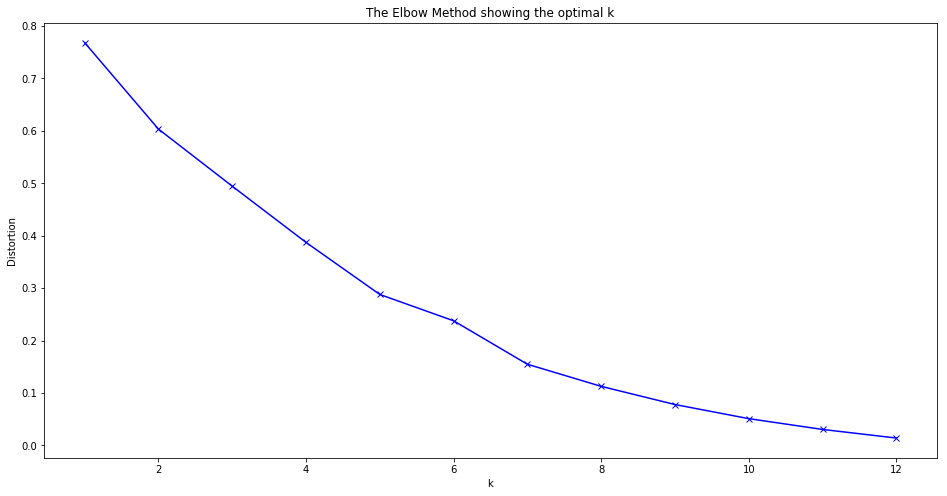

In [46]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

When examining the graph, there is not a distinct bend to indicate the optimum number of clusters.  However, there is a slight bend around 5, so I ran the k-means cluster analysis on the Foursquare data using 5 as the number of clusters.  The cluster numbers were then merged into a dataframe with the different types of venues.

In [47]:
# set number of clusters
kclusters = 5

sea_grouped_clustering = sea_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sea_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 0, 3, 4, 0, 0, 2], dtype=int32)

In [48]:
# add clustering labels
sea_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = seattle

# merge with seattle to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(sea_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head()

Neighborhood      District   Latitude   Longitude  \
0                   Atlantic  CENTRAL AREA  47.593588 -122.303870   
1                   Belltown      DOWNTOWN  47.615510 -122.344271   
2  Central Business District      DOWNTOWN  47.608184 -122.334878   
3                 First Hill      DOWNTOWN  47.609914 -122.323974   
4      Harrison/Denny-Blaine  CENTRAL AREA  47.623605 -122.287206   

   MedianIncome  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0         62180               1           Bus Station        Rental Service   
1         83543               0      Sushi Restaurant                Bakery   
2         68750               0           Coffee Shop                 Hotel   
3         47970               0        Sandwich Place           Coffee Shop   
4        185383               0           Dry Cleaner           Pizza Place   

     3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0                   Tunnel  South American Restaurant                  Park   
1               Restaurant               Cocktail Bar           Coffee Shop   
2  New American Restaurant        American Restaurant          Concert Hall   
3                   Lounge                      Hotel      Asian Restaurant   
4                     Café                Gas Station             Surf Spot   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Skate Park        Scenic Lookout                 Trail   
1    Italian Restaurant                   Bar     Convenience Store   
2        Clothing Store               Theater                   Spa   
3                Bakery                   Bar               Brewery   
4      Sushi Restaurant                   Spa                  Park   

  9th Most Common Venue                    10th Most Common Venue  
0                  Café  Residential Building (Apartment / Condo)  
1             Rock Club                                 Pet Store  
2           Music Venue                         French Restaurant  
3    Italian Restaurant                                 Nightclub  
4                   Gym                                    Bakery

After conducting the k-means analysis, I then generated a choropleth map including median income of each neighborhood and markers to indicate the different clusters.

# Results

## Neighborhood Clusters

##### Cluster 1

In [49]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

Neighborhood  MedianIncome  Cluster Labels  \
1                    Belltown         83543               0   
2   Central Business District         68750               0   
3                  First Hill         47970               0   
4       Harrison/Denny-Blaine        185383               0   
7                     Madrona        135293               0   
8                        Mann         98639               0   
10                Pike-Market         81782               0   
11             Pioneer Square         55479               0   

   1st Most Common Venue 2nd Most Common Venue    3rd Most Common Venue  \
1       Sushi Restaurant                Bakery               Restaurant   
2            Coffee Shop                 Hotel  New American Restaurant   
3         Sandwich Place           Coffee Shop                   Lounge   
4            Dry Cleaner           Pizza Place                     Café   
7              Gift Shop           Coffee Shop          Thai Restaurant   
8   Ethiopian Restaurant           Coffee Shop            Deli / Bodega   
10                 Hotel          Cocktail Bar              Coffee Shop   
11           Coffee Shop          Cocktail Bar                     Café   

   4th Most Common Venue    5th Most Common Venue 6th Most Common Venue  \
1           Cocktail Bar              Coffee Shop    Italian Restaurant   
2    American Restaurant             Concert Hall        Clothing Store   
3                  Hotel         Asian Restaurant                Bakery   
4            Gas Station                Surf Spot      Sushi Restaurant   
7             Playground       Italian Restaurant          Cupcake Shop   
8             Food Truck                      Bar            Taco Place   
10        Breakfast Spot  New American Restaurant    Italian Restaurant   
11    Italian Restaurant      Sporting Goods Shop                Lounge   

   7th Most Common Venue   8th Most Common Venue 9th Most Common Venue  \
1                    Bar       Convenience Store             Rock Club   
2                Theater                     Spa           Music Venue   
3                    Bar                 Brewery    Italian Restaurant   
4                    Spa                    Park                   Gym   
7     Seafood Restaurant       French Restaurant          Tennis Court   
8              Mini Golf              Donut Shop          Dessert Shop   
10     French Restaurant                  Bakery    Seafood Restaurant   
11    Mexican Restaurant  Thrift / Vintage Store   Dumpling Restaurant   

   10th Most Common Venue  
1               Pet Store  
2       French Restaurant  
3               Nightclub  
4                  Bakery  
7    Ethiopian Restaurant  
8     Fried Chicken Joint  
10          Deli / Bodega  
11              Pool Hall

This cluster was the largest.  The top venues in the above cluster are mainly coffee shops (first and second most common venues), but there are also a large number of restaurants of different varieties.  

##### Cluster 2

In [50]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

Neighborhood  MedianIncome  Cluster Labels 1st Most Common Venue  \
0     Atlantic         62180               1           Bus Station   

  2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
0        Rental Service                Tunnel  South American Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                  Park            Skate Park        Scenic Lookout   

  8th Most Common Venue 9th Most Common Venue  \
0                 Trail                  Café   

                     10th Most Common Venue  
0  Residential Building (Apartment / Condo)

This cluster only consisted of one neighborhood.  Venues were mostly related to travel and nature.

##### Cluster 3

In [51]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

Neighborhood  MedianIncome  Cluster Labels 1st Most Common Venue  \
9        Minor         64646               2           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
9              Bus Stop            Playground            Food Truck   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
9        Soccer Stadium               Theater     Convenience Store   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
9         Indie Theater           Art Gallery            Fish Market

There was only one neighborhood in this cluster.  The cluster consisted of many entertainment venues (e.g., soccer stadium, theater, indie theater, and art gallery).  

##### Cluster 4

In [52]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

Neighborhood  MedianIncome  Cluster Labels  \
5   International District         35122               3   
12          Yesler Terrace         36318               3   

    1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
5      Chinese Restaurant  Vietnamese Restaurant                Bakery   
12  Vietnamese Restaurant           Noodle House     Korean Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
5           Dessert Shop     Hotpot Restaurant                  Café   
12       Thai Restaurant            Poke Place        Sandwich Place   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
5        Bubble Tea Shop   Japanese Restaurant              Dive Bar   
12     Convenience Store     Food & Drink Shop    Chinese Restaurant   

   10th Most Common Venue  
5     Dumpling Restaurant  
12                 Garden

The fourth cluster had two neighborhoods and consisted mainly of Asian (Chinese, Vietnamese, Korean, Thai, and Japanese) restaurants.

##### Cluster 5

In [53]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 4, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

Neighborhood  MedianIncome  Cluster Labels 1st Most Common Venue  \
6       Leschi        111191               4                  Park   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
6            Playground   American Restaurant         Grocery Store   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
6             Pet Store           Pizza Place           Yoga Studio   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
6    Frozen Yogurt Shop   Fried Chicken Joint      French Restaurant

This cluster included only one neighborhood.  Top venues in this neighborhood were related to recreation (park, playground, yoga studio) and a few restaurants.

## Clusters and Median Income

To explore the median incomes of the neighborhoods, I generated a choropleth map of the median incomes of the neighborhoods of Seattle. 

In [54]:
#choropleth

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

map_clusters.choropleth(
    geo_data=seamap, #edit?
    data=seattle, #edit
    columns=['Neighborhood', 'MedianIncome'],
    key_on='feature.properties.S_HOOD', #change this?
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='',
    reset = True
)

map_clusters



I then added markers with different colors to indicate the different clusters. This map now displays the neighborhood clusters and median income in order to help identify the most common venues in each neighborhood and give an idea of potential menu prices.

In [55]:
#add clusters to map

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Discussion

For this project, I focused on the Downtown and Central Area districts.  Using the elbow method to test the k-means algorithm did not result in an obvious optimal number of clusters, and for the k-means cluster analyses I set the value to 5 clusters.  These clusters can be further explored by using the choropleth map to take into account the median income in the neighborhood.  

The largest cluster consisted of eight neighborhoods.  The highest median incomes for this cluster were on the east side, in the Madrona and Denny-Blaine neighborhoods.  A restaurant owner could potentially set higher menu prices in these neighborhoods than in First Hill and Pioneer Square, the neighborhoods with the lowest median incomes.  This cluster may consist of optimal neighborhoods since it seems to be a location where restaurants are common.  Potential restaurant owners and investors will want to carefully assess the types of restaurants in order to determine how much competition in each neighborhood.

The second largest cluster consisted of two neighborhoods, International District and Yesler Terrace. If opening a restaurant in this area, a business owner or investor should take into account that there are many Asian (Chinese, Vietnamese, Korean, and Japanese) restaurants in the neighborhood, and thus there may be a lot of competition if opening up a restaurant.  In addition, the median income of neighborhoods in this cluster is relatively low compared to other neighborhoods. Thus, it would likely be best to set lower menu price points.

There were three clusters that consisted of only one neighborhood each. These neighborhoods had the fewest venues each, and thus may not be ideal for opening up a restaurant.  One cluster consisted of Leschi, where the two most common venues were parks and playgrounds.  Leschi also had a relatively high median cost of living, and a restaurant owner could set higher menu prices in this neighborhood.  Another cluster consisted of the Atlantic neighborhood, and the top three venues were related to travel (bus station, rental service, and tunnel) and outdoors venues (park, skate park, scenic lookout, and trail).  There are fewer restaurants in this neighborhood, and this may not be the optimal place to open a restaurant because there may be less demand for a sit-down restaurant.  The final cluster consisted of only the Minor neighborhood.  Some of the most common venues in this neighborhood were coffee shops and food trucks.  This indicates that this may not be the best place to open up a restaurant either.  Other common venues were attractions, including soccer stadium, theater, indie theater, and art gallery.  This seems to be a neighborhood where people are most likely looking for quick food options.     

# Conclusion

As Seattle continues to grow, using data to determine optimal locations can be especially useful for future business owners and investors.  Leveraging Foursquare API data to examine the most common venues in neighborhoods provides extremely valuable information for potential business owners and investors.  By combining this data with information on median incomes, business owners can determine optimal neighborhoods and potential costs of menus.  In the present analyses, there were some challenges since the boundaries are somewhat informal and median incomes were not available from a single source.  In addition, there wasn’t a distinct optimal k identified using the elbow method. Further analyses can be done selecting different numbers of clusters to run the k-means analysis.  Nevertheless, I was able to identify some neighborhoods as less than optimal due to type of venues in the neighborhood.  When making a final decision, business owners may want to take into account other factors including population and real estate availability.